In [1]:
import os,sys,time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_datacube(fn):
    datacube = pd.read_csv(fn)
    flux_columns = [f'flux_{i}' for i in range(1000)]
    err_columns = [f'err_{i}' for i in range(1000)]

    flux_data = datacube[flux_columns].values
    err_data = datacube[err_columns].values
    params = datacube[['PLATE', 'MJD', 'FIBERID', 'OBJID', 'Z_SYS', 
                       'LOGMBH', 'LOGLBOL', 'LOGLEDD_RATIO']]
    return flux_data, err_data, params

In [3]:
# Read in the data
datacube = read_datacube('../training_data/DR16_speccube.dat')

In [4]:
import torch
import torch.nn as nn

sys.path.append('./scripts/')
from modules import *

In [54]:
nsamp_train = 8000
nsamp_valid = 1000
nsamp_test = 1000
nsamp_total = nsamp_train + nsamp_valid + nsamp_test

ind_train = np.random.choice(len(datacube[0]), nsamp_train, replace=False)
"""
ind_train = np.array([])
for zi in range(4):
    ind_z_range = np.where((datacube[2].Z_SYS.values>zi)&\
                           (datacube[2].Z_SYS.values<zi+1))[0]
    ind_train = np.append(ind_train, np.random.choice(ind_z_range, nsamp_train//4, replace=False))
"""
all_index_arr = np.arange(len(datacube[0]))
ind_mask_train = np.isin(all_index_arr, ind_train)
ind_valid = np.random.choice(all_index_arr[ind_mask_train], nsamp_valid, replace=False)
ind_test = np.random.choice(all_index_arr[~ind_mask_train], nsamp_test, replace=False)

In [55]:
X_train = torch.from_numpy(datacube[0][ind_train, :].astype(np.float32))
X_train_err = torch.from_numpy(datacube[1][ind_train, :].astype(np.float32))
mask_train = torch.tensor((X_train != 0)&(X_train_err > 0), dtype=torch.float32)
label_train = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_train].astype(np.float32), \
                                       ]).T)

X_valid = torch.from_numpy(datacube[0][ind_valid, :].astype(np.float32))
X_valid_err = torch.from_numpy(datacube[1][ind_valid, :].astype(np.float32))
mask_valid = torch.tensor((X_valid != 0)&(X_valid_err > 0), dtype=torch.float32)
label_valid = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_valid].astype(np.float32), \
                                        ]).T)

X_test_all = torch.from_numpy(datacube[0][ind_test, :].astype(np.float32))
X_test_err = torch.from_numpy(datacube[1][ind_test, :].astype(np.float32))
label_test = torch.from_numpy(np.stack([datacube[2].Z_SYS.values[ind_test].astype(np.float32), \
                                        ]).T)

(array([ 51., 170., 250., 235., 183.,  84.,  19.,   8.,   0.,   0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

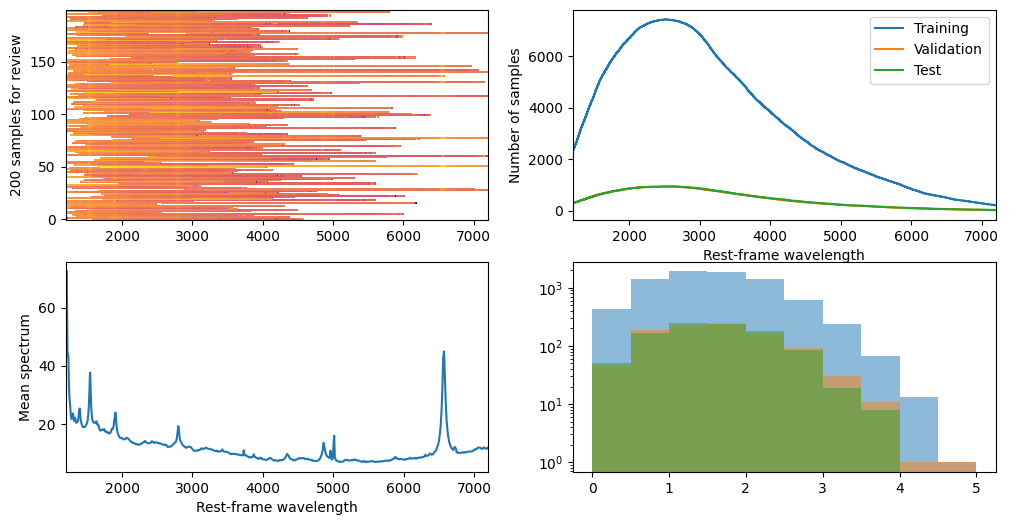

In [56]:
wave_grid = np.linspace(np.log10(1200), np.log10(7200), 1000)

fig, ax = plt.subplots(2,2, figsize=(12, 6))
X, Y = np.meshgrid(10**wave_grid, np.arange(200))
Z = np.vstack([np.log10(X_train[:200, :])])
ax[0, 0].pcolor(X, Y, Z, cmap='plasma')
ax[0, 0].set_ylabel('200 samples for review')

flux_projection = np.sum(X_train.detach().numpy(), axis=0)/np.sum((X_train.detach().numpy() != 0), axis=0)
ax[1, 0].plot(10**wave_grid, flux_projection)
ax[1, 0].set_xlim(1200, 7200)
ax[1, 0].set_xlabel('Rest-frame wavelength')
ax[1, 0].set_ylabel('Mean spectrum')

ax[0, 1].step(10**wave_grid, np.sum((X_train.detach().numpy() != 0), axis=0), where='mid', label='Training')
ax[0, 1].step(10**wave_grid, np.sum((X_valid.detach().numpy() != 0), axis=0), where='mid', label='Validation')
ax[0, 1].step(10**wave_grid, np.sum((X_test_all.detach().numpy() != 0), axis=0), where='mid', label='Test')
ax[0, 1].set_xlim(1200, 7200)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Rest-frame wavelength')
ax[0, 1].set_ylabel('Number of samples')

ax[1, 1].hist(datacube[2].Z_SYS.values[ind_train], bins=10, range=(0, 5), alpha=0.5, label='Training', log=True)
ax[1, 1].hist(datacube[2].Z_SYS.values[ind_valid], bins=10, range=(0, 5), alpha=0.5, label='Validation', log=True) 
ax[1, 1].hist(datacube[2].Z_SYS.values[ind_test], bins=10, range=(0, 5), alpha=0.5, label='Test', log=True)

In [57]:
x = X_train[:12]
mask = mask_train[:12]
patch_size=10

nsamp, npix = x.shape
x_patch = x.unfold(dimension=1, size=patch_size, step=patch_size)
mask_patch = mask.unfold(dimension=1, size=patch_size, step=patch_size)
mask_patch = (mask_patch.sum(dim=2) == patch_size).int()
print(mask_patch.shape, x_patch.shape)

embed = nn.Linear(10, 32)
x_embed = embed(x_patch)
pos_enc = nn.Parameter(torch.empty(1,  101, 32).normal_(mean=0, std=0.02))
x_pos = x_embed+pos_enc[:, 1:, :]
print(x_pos.shape)

N, L, D = x_pos.shape
        
fake_noise = torch.rand(N, L, device=x.device) 
fake_noise[mask_patch.bool()] = 0 # assign 0 to those with values (keep)

len_keep = int(L * 0.25)
ids_shuffle = torch.argsort(fake_noise, dim=1) # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)

ids_keep = ids_shuffle[:, :len_keep]
x_masked = torch.gather(x_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
mask_new = torch.ones([N, L], device=x.device)
mask_new[:, :len_keep] = 0
mask_new = torch.gather(mask_new, dim=1, index=ids_restore)
print(x_masked.shape, mask_new.shape, ids_restore.shape)

torch.Size([12, 100]) torch.Size([12, 100, 10])
torch.Size([12, 100, 32])
torch.Size([12, 25, 32]) torch.Size([12, 100]) torch.Size([12, 100])


In [58]:
N, L, D = 12, 100, 32

x_embed = embed(x_patch)
print(x_embed.shape)

noise = torch.rand(N, L)  # noise in [0, 1]
noise[mask_patch == 1] = 0  # set noise to 0 where data is available
print(noise.shape)
#print(noise)

ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
print(ids_shuffle.shape)
#print(ids_shuffle)

ids_restore = torch.argsort(ids_shuffle, dim=1)
print(ids_restore.shape)
#print(ids_restore)

# keep the first subset
ids_keep = ids_shuffle[:, :25]
print(ids_keep.shape)
#print(ids_keep)

print(ids_keep.unsqueeze(-1).repeat(1, 1, D).shape)
x_masked = torch.gather(x_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
print(x_masked.shape)

torch.Size([12, 100, 32])
torch.Size([12, 100])
torch.Size([12, 100])
torch.Size([12, 100])
torch.Size([12, 25])
torch.Size([12, 25, 32])
torch.Size([12, 25, 32])


In [59]:
class TransformerBlock(nn.Module):
    def __init__(self, 
                 embedding_dim, num_heads, 
                 forward_expansion, dropout,
                 device, 
                 ):
        super().__init__()

        ##self.attention = SelfAttention(embedding_dim, num_heads)
        self.multihead_attn = torch.nn.MultiheadAttention(
                        embed_dim=embedding_dim,
                        num_heads=num_heads,
                        dropout=dropout,
                        device=device)
        
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, forward_expansion * embedding_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * embedding_dim, embedding_dim),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_query, input_value, input_key, \
                mask=None):
        # attention_out = self.attention(input_query, input_key, input_value, mask)
        attenion_out, _ = self.multihead_attn(query = input_query, \
                                            value = input_value,
                                            key = input_key, 
                                            key_padding_mask=mask)
        x_in = self.norm1(input_query + attenion_out)
        x_out = self.feed_forward(x_in)
        x_result = self.norm2(x_out+x_in)
        return x_result

class Encoder(nn.Module):
    def __init__(self, 
                 embedding_dim, num_heads, num_layers, 
                 forward_expansion, dropout, device):
        super().__init__()

        self.norm1 = nn.LayerNorm(embedding_dim)

        self.layers = nn.ModuleList([
                    TransformerBlock(embedding_dim, num_heads, 
                                    forward_expansion, dropout, device
                                    ) for _ in range(num_layers)  ])

    def forward(self, x, mask=None):
        x = self.norm1(x)

        for layer in self.layers:
            x = layer(x, x, x, mask)

        return x

class Decoder(nn.Module):
    def __init__(self, 
                 embedding_dim, num_heads, num_layers, 
                 forward_expansion, dropout, device):
        super().__init__()

        #self.norm2 = nn.LayerNorm(embedding_dim)
        
        self.layers = nn.ModuleList([
                    TransformerBlock(embedding_dim, num_heads, 
                                    forward_expansion, dropout, device
                                    ) for _ in range(num_layers)  ])

    def forward(self, x, encoder_val, encoder_key, mask=None):
        for layer in self.layers:
            x = layer(x, encoder_val, encoder_key, mask)
        return x

class spec_masked_Transformer(nn.Module):
    def __init__(self, 
                 input_size, 
                 patch_size, 
                 label_size,
                 embedding_dim = 128,
                 decoder_embedding_dim = 64,
                 #max_length = 1000, 
                 num_heads = 8,
                 num_layers = 3, 
                 forward_expansion = 4, 
                 dropout = 0, 
                 device='mps',
                 ):
        super().__init__()

        self.patch_size = patch_size
        self.nlabels = label_size

        # ----------------------------------------------------------
        # MAE Encoder

        self.embed_spec = nn.Linear(patch_size, embedding_dim)
        self.embed_label = nn.Linear(1, embedding_dim)

        num_patches = input_size // patch_size
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        #self.pos_enc = nn.Parameter(torch.zeros(1, num_patches + label_size, embedding_dim), requires_grad=False)  # fixed sin-cos embedding
        self.pos_enc = nn.Parameter(torch.empty(1,  num_patches + 1, embedding_dim).normal_(mean=0, std=0.02))

        self.encoder_block = Encoder(embedding_dim, num_heads, num_layers, 
                               forward_expansion, dropout, device)
        self.encoder_norm = nn.LayerNorm(embedding_dim)
        
        # ----------------------------------------------------------
        # MAE Decoder

        self.decoder_embedding = nn.Linear(embedding_dim, decoder_embedding_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embedding_dim))

        #self.decoder_pos_enc = nn.Parameter(torch.zeros(1, num_patches + label_size, decoder_embedding_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_pos_enc = nn.Parameter(torch.empty(1,  num_patches + label_size, decoder_embedding_dim).normal_(mean=0, std=0.02))
        
        self.decoder_block = Decoder(decoder_embedding_dim, num_heads, num_layers, 
                               forward_expansion, dropout, device)
        
        self.decoder_norm = nn.LayerNorm(decoder_embedding_dim)
        self.decoder_pred = nn.Linear(decoder_embedding_dim, patch_size, bias=True)

        # ----------------------------------------------------------
        # Initialize the weights
        
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

    def patchify(self, x, mask):
        # x: (nsamp, npix)
        # mask: (nsamp, npix) for 0 is masked, 1 is keep
        assert x.shape[1] % self.patch_size == 0 and mask.shape == x.shape
        x_patch = x.unfold(dimension=1, size=self.patch_size, step=self.patch_size)
        mask_patch = mask.unfold(dimension=1, size=self.patch_size, step=self.patch_size)
        mask_patch_keep = (mask_patch.sum(dim=2) == self.patch_size).int()
        # x_patch: (nsamp, num_patches, patch_size)
        # mask_patch_keep: (nsamp, num_patches) for 0 is masked, 1 is keep
        return x_patch, mask_patch_keep

    def add_mask(self, x, mask, ratio_keep=0.3):
        # x: (nsamp, num_patches, embedding_dim)
        # mask: (nsamp, num_patches) for 0 is masked, 1 is keep
        N, L, D = x.shape
        
        fake_noise = torch.rand(N, L, device=x.device) 
        fake_noise[mask == 0] = 1 # assign 1 to missing patches

        len_keep = int(L * ratio_keep)
        ids_shuffle = torch.argsort(fake_noise, dim=1) # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        mask_new = torch.ones([N, L], device=x.device)
        mask_new[:, :len_keep] = 0
        mask_new = torch.gather(mask_new, dim=1, index=ids_restore)

        return x_masked, mask_new, ids_restore

    def forward_encoder(self, x, labels, mask):
        # x: (nsamp, npix)
        # labels: (nsamp, 1)
        if mask is None:
            mask = torch.ones(x.shape)
            # 1 is keep, 0 is masked/removed

        x_patch, mask_patch = self.patchify(x, mask)
        # x_patch: (nsamp, num_patches, patch_size)
        # mask_patch: (nsamp, num_patches) for 0 is masked, 1 is keep

        x_embed = self.embed_spec(x_patch)
        # x_embed: (nsamp, num_patches, embedding_dim)

        x_pos = x_embed + self.pos_enc[:, 1:, :]
        # x_pos: (nsamp, num_patches, embedding_dim)

        x_masked, mask_new, ids_restore = self.add_mask(x_pos, mask_patch)
        # x_masked: (nsamp, num_patches, embedding_dim)
        # mask_new: (nsamp, num_patches) for 0 is keep, 1 is masked
        # ids_restore: (nsamp, num_patches) for the index of the restored patches

        #labels = self.embed_label(labels.unsqueeze(-1))
        label_token = self.cls_token + self.pos_enc[:, :1, :]
        label_token = label_token.expand(x_masked.shape[0], -1, -1)
        # label_tokens: (nsamp, 1) -> (nsamp, 1, 1) -> (nsamp, 1, embedding_dim)
        # label_tokens: (nsamp, 1, embedding_dim)

        x_input = torch.cat((label_token, x_masked), dim=1)
        # x: (nsamp, 1+num_patches, embedding_dim)

        latent = self.encoder_block(x_input)
        latent_norm = self.encoder_norm(latent)
        
        return latent_norm, mask_new, ids_restore
    
    def forward_decoder(self, x, ids_restore):
        # x: (nsamp, 1+num_patches, embedding_dim)
        # ids_restore: (nsamp, num_patches)

        x_embed = self.decoder_embedding(x)
        # x_embed: (nsamp, 1+num_patches, decoder_embedding_dim)

        mask_tokens = self.mask_token.repeat(x_embed.shape[0], ids_restore.shape[1] + 1 - x_embed.shape[1], 1)
        # mask_tokens: (nsamp, num_patches, decoder_embedding_dim)

        x_ = torch.cat([x_embed[:, 1:, :], mask_tokens], dim=1)  # no label token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_embed.shape[2]))  # unshuffle
        x_all = torch.cat([x_embed[:, :1, :], x_], dim=1)  # append label token
        # x_all: (nsamp, 1+num_patches, decoder_embedding_dim)

        x_pos = x_all + self.decoder_pos_enc
        # x_pos: (nsamp, 1+num_patches, decoder_embedding_dim)

        x_out = self.decoder_block(x_pos, x_pos, x_pos)
        x_norm = self.decoder_norm(x_out)

        x_pred = self.decoder_pred(x_norm)
        # x_pred: (nsamp, 1+num_patches, patch_size)

        x_label = x_pred[:, :1, :].mean(dim=2)
        x_spec = x_pred[:, 1:, :]
        x_spec = x_spec.reshape(x_spec.shape[0], -1)
        # x_spec: (nsamp, npix)

        return x_spec, x_label

    def forward(self, x, labels, mask):
        # x: (nsamp, npix)
        # labels: (nsamp, 1)

        latent, mask, ids_restore = self.forward_encoder(x, labels, mask)
        pred = self.forward_decoder(latent, ids_restore)

        return pred


In [60]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)
nsamp = len(X_train)
npix = X_train.shape[1]
nlabel = label_train.shape[1]

model = spec_masked_Transformer(input_size=npix, patch_size = 10, label_size=nlabel, device=device, \
                         dropout = 0.1)
model.to(device)

mps


spec_masked_Transformer(
  (embed_spec): Linear(in_features=10, out_features=128, bias=True)
  (embed_label): Linear(in_features=1, out_features=128, bias=True)
  (encoder_block): Encoder(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (decoder_embedding): Linear(in_features=

In [61]:
nepoch = 100
batch_size = 32
loss_epoch = []
loss_valid_epoch = []
best_loss = 1e6

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(nepoch):
    t0 = time.time()
    model.train()
    for i in range(0, nsamp_train-batch_size, batch_size):
        optimizer.zero_grad()
        X_batch = X_train[i:i+batch_size]
        X_batch_err = X_train_err[i:i+batch_size]
        mask_batch = mask_train[i:i+batch_size]
        label_batch = label_train[i:i+batch_size]
        #Y_pred = model(X_batch)
        #loss = masked_mse_loss(X_batch, Y_pred, mask_batch)
        #loss = masked_gaussian_likelihood(X_batch, Y_pred[0], mask_batch, X_batch_err)

        #X_batch_missed = generate_missing_pixel(X_batch, missing_rate=np.random.uniform(0, 0.5, 1))
        #mask_batch_missed = torch.tensor((X_batch_missed != 0)&(X_batch_err>0), dtype=torch.float32)    
        #Y_pred, _ = model(X_batch_missed.to(device), label_batch.to(device), mask_batch_missed.to(device))
        Y_pred, _ = model(X_batch.to(device), label_batch.to(device), mask_batch.to(device))
        loss = masked_gaussian_likelihood(X_batch.to(device), Y_pred.to(device), mask_batch.to(device), X_batch_err.to(device))
        
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.item())

    model.eval()
    with torch.no_grad():
        Y_valid, _ = model(X_valid.to(device), label_valid.to(device), mask_valid.to(device))
        loss_valid = masked_gaussian_likelihood(X_valid.to(device), Y_valid.to(device), mask_valid.to(device), X_valid_err.to(device))
    loss_valid_epoch.append(loss_valid.item())
    print(f"Epoch {epoch+1}, loss={loss.item():.2f}, valid_loss={loss_valid.item():.2f}, time={time.time()-t0:.2f}s")

    if loss_valid < best_loss:
        best_loss = loss_valid
        torch.save(model.state_dict(), './saved_model/SpecTransformer_Dec04_MAE')
        print(f'Model saved (epoch={epoch+1})')

Epoch 1, loss=258.10, valid_loss=350.51, time=36.61s
Model saved (epoch=1)
Epoch 2, loss=226.46, valid_loss=316.56, time=14.68s
Model saved (epoch=2)
Epoch 3, loss=205.79, valid_loss=294.13, time=15.04s
Model saved (epoch=3)
Epoch 4, loss=196.14, valid_loss=283.70, time=15.19s
Model saved (epoch=4)
Epoch 5, loss=188.04, valid_loss=274.93, time=14.14s
Model saved (epoch=5)
Epoch 6, loss=181.93, valid_loss=268.93, time=11.63s
Model saved (epoch=6)
Epoch 7, loss=177.41, valid_loss=263.72, time=10.93s
Model saved (epoch=7)
Epoch 8, loss=173.22, valid_loss=258.80, time=11.14s
Model saved (epoch=8)
Epoch 9, loss=169.40, valid_loss=254.52, time=12.07s
Model saved (epoch=9)
Epoch 10, loss=170.43, valid_loss=257.84, time=11.37s
Epoch 11, loss=166.95, valid_loss=253.48, time=10.48s
Model saved (epoch=11)
Epoch 12, loss=165.73, valid_loss=252.05, time=10.67s
Model saved (epoch=12)
Epoch 13, loss=163.01, valid_loss=249.07, time=10.92s
Model saved (epoch=13)
Epoch 14, loss=160.21, valid_loss=245.76

In [ ]:
nepoch = 100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(nepoch):
    t0 = time.time()
    model.train()
    for i in range(0, nsamp_train-batch_size, batch_size):
        optimizer.zero_grad()
        X_batch = X_train[i:i+batch_size]
        X_batch_err = X_train_err[i:i+batch_size]
        mask_batch = mask_train[i:i+batch_size]
        label_batch = label_train[i:i+batch_size]
        #Y_pred = model(X_batch)
        #loss = masked_mse_loss(X_batch, Y_pred, mask_batch)
        #loss = masked_gaussian_likelihood(X_batch, Y_pred[0], mask_batch, X_batch_err)

        #X_batch_missed = generate_missing_pixel(X_batch, missing_rate=np.random.uniform(0, 0.5, 1))
        #mask_batch_missed = torch.tensor((X_batch_missed != 0)&(X_batch_err>0), dtype=torch.float32)    
        #Y_pred, _ = model(X_batch_missed.to(device), label_batch.to(device), mask_batch_missed.to(device))
        Y_pred, _ = model(X_batch.to(device), label_batch.to(device), mask_batch.to(device))
        loss = masked_gaussian_likelihood(X_batch.to(device), Y_pred.to(device), mask_batch.to(device), X_batch_err.to(device))
        
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.item())

    model.eval()
    with torch.no_grad():
        Y_valid, _ = model(X_valid.to(device), label_valid.to(device), mask_valid.to(device))
        loss_valid = masked_gaussian_likelihood(X_valid.to(device), Y_valid.to(device), mask_valid.to(device), X_valid_err.to(device))
    loss_valid_epoch.append(loss_valid.item())
    print(f"Epoch {epoch+1}, loss={loss.item():.2f}, valid_loss={loss_valid.item():.2f}, time={time.time()-t0:.2f}s")

    if loss_valid < best_loss:
        best_loss = loss_valid
        torch.save(model.state_dict(), './saved_model/SpecTransformer_Dec04_MAE')
        print(f'Model saved (epoch={epoch+1})')

Epoch 1, loss=64.91, valid_loss=110.96, time=24.42s
Model saved (epoch=1)
Epoch 2, loss=64.76, valid_loss=111.71, time=11.39s


Text(0.5, 0, 'Epoch')

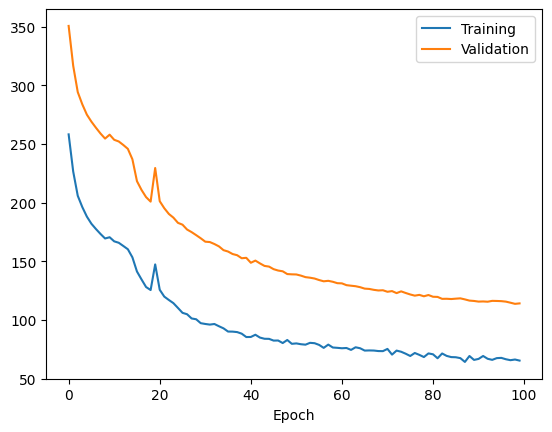

In [62]:
plt.plot(loss_epoch, label='Training')
plt.plot(loss_valid_epoch, label='Validation')
plt.legend()
plt.xlabel('Epoch')

In [63]:
best_model = spec_masked_Transformer(input_size=npix, patch_size = 10, label_size=nlabel, device=device, \
                         dropout = 0.1)
best_model.load_state_dict(torch.load('./saved_model/SpecTransformer_Dec04_MAE'))
best_model.to(device)

spec_masked_Transformer(
  (embed_spec): Linear(in_features=10, out_features=128, bias=True)
  (embed_label): Linear(in_features=1, out_features=128, bias=True)
  (encoder_block): Encoder(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (decoder_embedding): Linear(in_features=

In [ ]:
best_model.eval()

ind_test_plot = np.sort(np.random.choice(nsamp_test, 100, replace=False))
mask_test = torch.tensor((X_test_all != 0)&(X_test_err > 0), dtype=torch.float32)

with torch.no_grad():
    Y_reconstructed, label_pred_all = best_model(X_test_all.to(device), label_test.to(device), mask_test.to(device))

with PdfPages('./figs/test3_MAE.pdf') as pdf:
    for i in ind_test_plot:
        Y_pred = Y_reconstructed[i]
        loss = masked_gaussian_likelihood(X_test_all[i].to(device), Y_pred, mask_test[i].to(device), X_test_err[i].to(device))

        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.set_position([0.08, 0.15, 0.85, 0.8])

        ax.plot(10**wave_grid, flux_projection, c='silver', alpha=0.5, label='Mean spectrum', zorder=-1)
        ax.plot(10**wave_grid, X_test_all[i], c='k', label='Original spectrum', zorder=1)
        ax.plot(10**wave_grid, X_test_err[i], c='k', ls=':', label='Error', zorder=1)

        ax.plot(10**wave_grid, Y_pred.cpu().detach().numpy(), \
                c='orange', label='Reconstructed spectrum (30% patches)', lw=0.5, zorder=2, alpha=0.9)
        
        ax.legend()
        ax.text(0.98, 0.98, r"train#%d, z=%.2f"%(i, label_test[i]), \
                ha='right', va='top', transform=ax.transAxes)
        ax.text(0.98, 0.90, r"loss=%.2f"%(np.around(loss.cpu(),2), ), \
                ha='right', va='top', transform=ax.transAxes)
        
        ax.axvline(1215.67, ls=':', c='grey', lw=0.5)
        ax.axvline(1549.06, ls=':', c='grey', lw=0.5)
        ax.axvline(1908.73, ls=':', c='grey', lw=0.5)
        ax.axvline(2798.75, ls=':', c='grey', lw=0.5)
        ax.axvline(4862.68, ls=':', c='grey', lw=0.5)
        ax.axvline(6564.61, ls=':', c='grey', lw=0.5)
        ax.set_xlabel('Rest-frame wavelength')
        ax.set_ylabel('Flux')
        ax.set_xlim(1200, 7200)
        pdf.savefig(fig)
        plt.close()
